# Deviation survey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Suppress e notation
np.set_printoptions(suppress=True)

## BUGS

- Doesn't add a zero/zero point at the top... should add KB
- Doesn't work past the last deviation point... should add TD
- Get NaNs with min curvature for the real survey, probably the `tan` ? 

## Small example

http://www.docslide.com/pete-661-drilling-engineering-2/

In [245]:
small = """md, inc, azi
3000, 0, 20
3200, 6, 6
3600, 14, 20
4000, 24, 80"""

In [246]:
import pandas as pd

In [247]:
from io import StringIO
df = pd.read_csv(StringIO(small), sep=',')
df.head()

,md,inc,azi
0,3000,0,20
1,3200,6,6
2,3600,14,20
3,4000,24,80


In [248]:
md = df.values[:,0]
inc = df.values[:,1]
azi = df.values[:,2]

Find the coordinates of point 3, given the coordinates of point 2.

## Average angle

In [266]:
def position_log(deviation, td=None, method='mc', return_deviation=False):
    """
    Args:
        deviation (ndarray): A deviation survey with rows like MD, INC, AZI
        method (str):
            'aa': average angle
            'bt': balanced tangential
            'mc': minimum curvature
        
    Returns:
        ndarray. A position log with rows like X-offset, Y-offset, Z-offset
    """
    # Adjust to TD.
    if td is not None:
        last_row = np.copy(deviation[-1, :])
        last_row[0] = td
        deviation = np.vstack([deviation, last_row])

    # Adjust to surface if necessary.
    if deviation[0,0] > 0:
        deviation = np.vstack([np.array([0, 0, 0]), deviation])

    last = deviation[:-1]
    this = deviation[1:]

    diff = this[:,0] - last[:,0]

    Ia = np.radians(last[:,1])
    Ib = np.radians(this[:,1])
    Aa = np.radians(last[:,2])
    Ab = np.radians(this[:,2])
    
    if method == 'aa':
        Iavg = (Ia + Ib) / 2
        Aavg = (Aa + Ab) / 2
        delta_N = diff * np.sin(Iavg) * np.cos(Aavg)
        delta_E = diff * np.sin(Iavg) * np.sin(Aavg)
        delta_V = diff * np.cos(Iavg)

    elif method in ('bt', 'mc'):
        delta_N =  0.5 * diff * np.sin(Ia) * np.cos(Aa)
        delta_N += 0.5 * diff * np.sin(Ib) * np.cos(Ab)

        delta_E =  0.5 * diff * np.sin(Ia) * np.sin(Aa)
        delta_E += 0.5 * diff * np.sin(Ib) * np.sin(Ab)

        delta_V =  0.5 * diff * np.cos(Ia)
        delta_V += 0.5 * diff * np.cos(Ib)

#     elif method == 'rc':
#         # This method does not work with the TD adjustment.
#         delta_N = diff * (np.cos(Ia) - np.cos(Ib)) * (np.sin(Ab) - np.sin(Aa))
#         divisor = (Ib - Ia)*(Ab - Aa)
#         divisor[divisor==0] = 0.000000001
#         delta_N = delta_N / divisor

#         delta_E = diff * (np.cos(Ia) - np.cos(Ib)) * (np.cos(Aa) - np.cos(Ab))
#         delta_E = delta_E / divisor

#         delta_V = diff * (np.sin(Ib) - np.sin(Ia))
#         divisor = Ib - Ia
#         divisor[divisor==0] = 0.000000001    
#         delta_V = delta_V / divisor

    else:
        raise Exception("Method must be one of 'aa', 'bt', 'mc'")

    if method == 'mc':
        _x = np.sin(Ib) * (1 - np.cos(Ab - Aa))
        dogleg = np.arccos(np.cos(Ib - Ia) - np.sin(Ia) * _x)
        rf = 2 / dogleg * np.tan(dogleg / 2)  # ratio factor
        rf[np.isnan(rf)] = 1  # Adjust for NaN.
        delta_N *= rf
        delta_E *= rf
        delta_V *= rf
    
    # Prepare the output array.
    result = np.zeros_like(deviation, dtype=np.float)
    
    # Stack the results, add the surface.
    _offsets = np.squeeze(np.dstack([delta_N, delta_E, delta_V]))
    _offsets = np.vstack([np.array([0, 0, 0]), _offsets])
    result += _offsets.cumsum(axis=0)

    if return_deviation:
        return result, deviation
    else:
        return result

In [267]:
pts, _ = position_log(df.values, td=4250, method='mc', return_deviation=True)
pts

array([[    0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  3000.        ],
       [   10.405095  ,     1.09361955,  3199.63465947],
       [   76.77891904,    19.86014923,  3593.28741268],
       [  137.0262308 ,   117.58257029,  3974.19717602],
       [  154.68350001,   217.72192017,  4202.58354043]])

In [257]:
from scipy.interpolate import splprep, splev

data = pts * [1,1,-1]

# Fit the spline and fetch 400 points.
knees, _ = splprep(data.T, s=0, k=3)
spline = splev(np.linspace(0, 1, 400), knees)

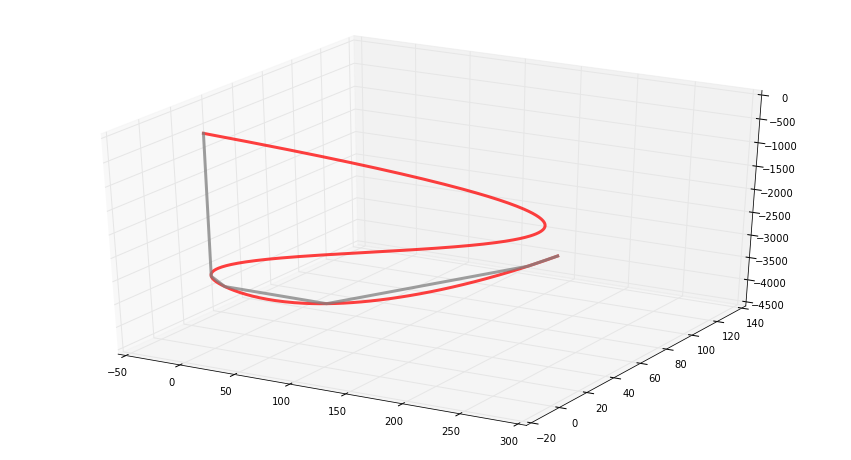

In [211]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(15,8))
plt.gca(projection='3d')
plt.plot(*spline, color='red', lw=3, alpha=0.75)
plt.plot(*data.T, color='grey', lw=3, alpha=0.75)
plt.show()

## Real example

In [268]:
dev_file = '/Users/matt/Dropbox/dev/recipes/data/deviation/P-130_deviation_survey.csv'

In [269]:
df = pd.read_csv(dev_file, sep=',')
df.head()

,MD,INC,AZI,TVDKB
0,18,0.3,0,18
1,38,0.5,0,38
2,57,1.5,0,57
3,84,1.8,0,84
4,104,0.5,0,104


In [270]:
md = df['MD'].values
inc = df['INC'].values
azi = df['AZI'].values
tvdkb = df['TVDKB'].values
del df['TVDKB']

In [271]:
tvdkb[-5:]

array([ 2491.09,  2510.28,  2539.16,  2558.45,  2577.78])

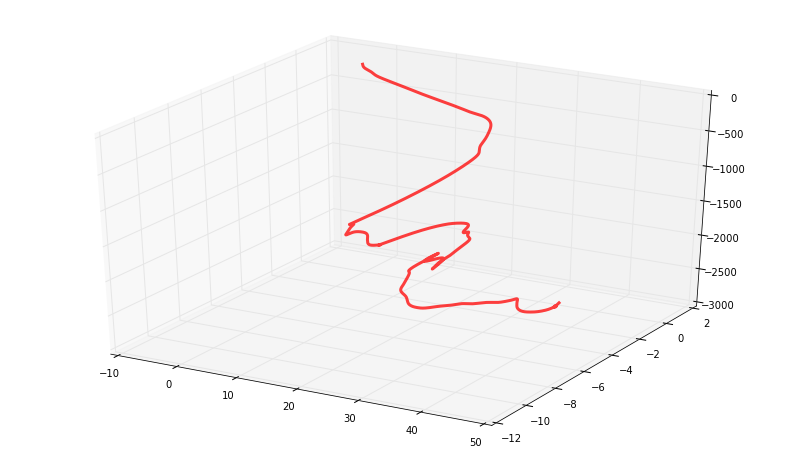

In [273]:
pts, dev = position_log(df.values, td=2618, method='mc', return_deviation=True)

data = pts * [1,1,-1]

knots, _ = splprep(data.T, s=0, k=3)
spline = splev(np.linspace(0, 1, 10000), knots)

plt.figure(figsize=(14,8))
plt.gca(projection='3d')
plt.plot(*spline, color='red', lw=3, alpha=0.75)
plt.show()

## Interpolating values

In [274]:
tvd = pts[:,2]
md = dev[:,0]

In [275]:
from scipy.interpolate import interp1d

In [276]:
md2tvd = interp1d(md, tvd, kind='cubic', assume_sorted=True)
md2tvd(2000)

array(1998.1793176178812)

In [277]:
tvd2md = interp1d(tvd, md, kind='cubic', assume_sorted=True)
tvd2md(1998.107873)

array(1999.9285337569947)